# 02 - Prepare train-test split

Again, this notebook is for info only.  The developed data processing functions have been abstracted into the energy_forecast package, orchestrated by the `03_prepare_train_test.py` script.

You may prepare these files from the commandline using:
```bash
make preprocess_data
```

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import energy_forecast
from energy_forecast.loaders import load_ods, load_ods_sheetnames
from energy_forecast.transform import (
    clean_energy_data,
    clean_temp_data,
    clean_wind_data,
)
from energy_forecast.transform import clean_sun_data, clean_rain_data
from energy_forecast.utils import repo_root
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.transformations.series.detrend import STLTransformer
from statsmodels.graphics.tsaplots import month_plot, plot_acf
from pathlib import Path

In [3]:
REPO_ROOT = Path(repo_root())
DATA_INTERIM = REPO_ROOT / "data" / "interim"
DATA_FILE_PATH = DATA_INTERIM / "transformed_energy_weather.csv"
DATA_PROCESSED = REPO_ROOT / "data" / "processed"

In [4]:
def load_and_set_types(path: str) -> pd.DataFrame:
    df = (
        pd.read_csv(path)
        .assign(datetime=lambda x: pd.to_datetime(x["datetime"], format="%Y-%m-%d"))
        .set_index("datetime", drop=True)
    )
    return df


df = load_and_set_types(DATA_FILE_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 384 entries, 1991-01-01 to 2022-12-01
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_energy       330 non-null    float64
 1   coal               330 non-null    float64
 2   petroleum          330 non-null    float64
 3   natural gas        330 non-null    float64
 4   bioenergy & waste  330 non-null    float64
 5   elec_nuclear       330 non-null    float64
 6   elec_renewable     294 non-null    float64
 7   elec_import        306 non-null    float64
 8   temp               380 non-null    float64
 9   wind               260 non-null    float64
 10  sun                260 non-null    float64
 11  rain               260 non-null    float64
dtypes: float64(12)
memory usage: 39.0 KB


In [5]:
weather_cols = {
    "temp": "degC",
    "wind": "knots",
    "sun": "hours",
    "rain": "mm",
}
energy_cols = {
    "total_energy": "mtoe",
    "coal": "mtoe",
    "petroleum": "mtoe",
    "natural gas": "mtoe",
    "bioenergy & waste": "mtoe",
    "elec_nuclear": "mtoe",
    "elec_renewable": "mtoe",
    "elec_import": "mtoe",
}
combined_cols = dict(**energy_cols, **weather_cols)

## Check weather columns

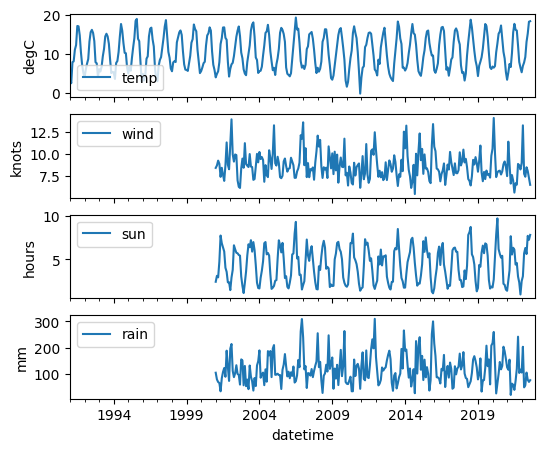

In [6]:
fig = plt.figure(figsize=(6, 5))
for i, (col, unit) in enumerate(weather_cols.items()):
    sharex = ax if i > 0 else None
    ax = fig.add_subplot(4, 1, i + 1, sharex=sharex)
    df.plot(y=col, color="C0", ax=ax)
    ax.set_ylabel(unit)

## Check energy columns

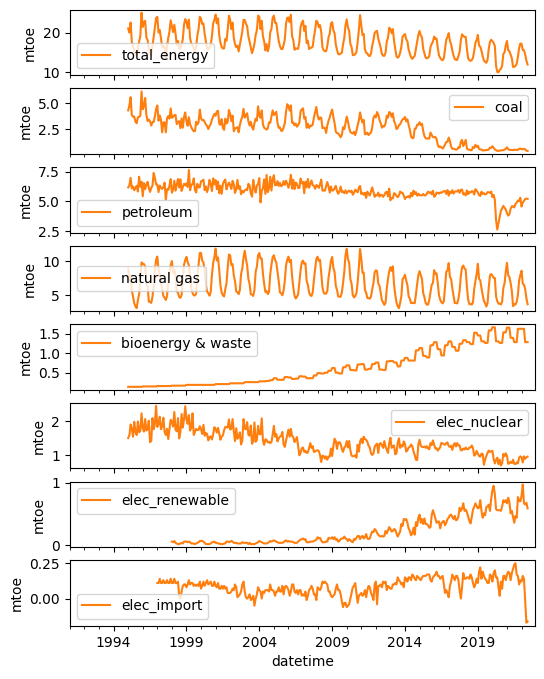

In [7]:
fig = plt.figure(figsize=(6, 8))
for i, (col, unit) in enumerate(energy_cols.items()):
    sharex = ax if i > 0 else None
    ax = fig.add_subplot(len(energy_cols), 1, i + 1, sharex=sharex)
    df.plot(y=col, color="C1", ax=ax)
    ax.set_ylabel(unit)
# fig.tight_layout()

## Deal with missing data

- Limited data prior to 2001-01.  We will drop rows prior to this
- Similarly, limited data after 2022-06. drop rows.
- We have complete data between these dates.

In [8]:
def crop_data(df: DataFrame) -> DataFrame:
    df = df.loc["2001-01-01":"2022-06-01"]
    return df


df = crop_data(df)
df

,total_energy,coal,petroleum,natural gas,bioenergy & waste,elec_nuclear,elec_renewable,elec_import,temp,wind,sun,rain
datetime,,,,,,,,,,,,
2001-01-01,24.53,3.80,6.78,11.83,0.21,1.78,0.04,0.09,3.900000,8.425950,2.448102,103.481072
2001-02-01,22.30,4.21,6.01,10.08,0.21,1.67,0.04,0.08,4.800000,8.703050,3.125319,77.799117
2001-03-01,23.62,4.28,6.64,10.54,0.21,1.81,0.03,0.11,5.452066,9.246000,2.953300,67.968746
2001-04-01,19.31,3.01,5.67,8.67,0.21,1.65,0.03,0.07,7.806906,8.893600,4.744445,64.001636
2001-05-01,17.42,2.90,6.30,6.46,0.21,1.46,0.02,0.07,12.438507,7.419400,7.725524,32.301995
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-01,15.59,0.49,4.88,6.68,1.62,0.79,0.97,0.16,6.835289,13.218102,3.072332,202.980819
2022-03-01,15.49,0.54,5.01,6.54,1.62,0.97,0.67,0.14,7.717512,7.767567,5.684977,47.402353
2022-04-01,14.41,0.49,5.19,5.91,1.28,0.90,0.65,-0.01,9.134444,7.432602,6.303121,55.806545


# Split off Training and evaluation set

In timeseries especially, we should ideally develop our models on a train and test subset, and keep a final evaluation hold out set for final model 

In [18]:
# Temporal split into train and test sets
train, test = temporal_train_test_split(df, test_size=0.25)

print(f"{train.shape=}")
print(f"{test.shape=}")

train.shape=(193, 12)
test.shape=(65, 12)


In [10]:
# Comment out below lines so we can abstract out all the processing steps
# Into easily runnable python scripts

# train.to_csv(DATA_PROCESSED / 'train.csv')
# test.to_csv(DATA_PROCESSED / 'test.csv')

# Check the data loads in ok

In [19]:
train = load_and_set_types(DATA_PROCESSED / "train.csv")
test = load_and_set_types(DATA_PROCESSED / "test.csv")

print(f"{train.shape=}")
print(f"{test.shape=}")

train.shape=(193, 12)
test.shape=(65, 12)
